# 1

In [1]:
import numpy as np
import cvxpy as cp
from scipy.linalg import solve_banded
from time import time
np.random.seed(78)
np.set_printoptions(precision=4)

delta = 1
eta = 1
n = 4000
k = 100

Y = np.random.randn(n, k)
b = np.random.randn(k)
c = Y.dot(b)
X = np.identity(n) * eta
X[np.arange(n - 1), np.arange(n - 1) + 1] -= delta
X[np.arange(n - 1) + 1, np.arange(n - 1)] -= delta
X[np.arange(n - 1), np.arange(n - 1)] += delta
X[np.arange(n - 1) + 1, np.arange(n - 1) + 1] += delta

def naive():
    A = X + Y.dot(Y.T)
    x = np.linalg.solve(A, c)
    return x

def smart():
    X = np.zeros((3, n))
    X[0][1:] -= delta
    X[2][:-1] -= delta
    X[1][:-1] += delta
    X[1][1:] += delta
    X[1] += eta
    q = np.identity(k) + np.dot(Y.T, solve_banded((1, 1), X, Y))
    y = np.linalg.solve(q, np.dot(Y.T, solve_banded((1, 1), X, c)))
    x = solve_banded((1, 1), X, c - np.dot(Y, y))
    return x

def main():
    t0 = time()
    x_naive = naive()
    t1 = time()
    t_naive = t1 - t0

    t0 = time()
    x_smart = smart()
    t1 = time()
    t_smart = t1 - t0

    l2 = np.linalg.norm
    print(f"l2(diff) / l2(x_naive) = {l2(x_smart - x_naive) / l2(x_naive)}")
    print(f"Time for naive: {t_naive}")
    print(f"Time for smart: {t_smart}")
    print(f"Time ratio: {t_naive / t_smart:.2f}")

main()


l2(diff) / l2(x_naive) = 2.079451888488464e-12
Time for naive: 1.4343960285186768
Time for smart: 0.014971017837524414
Time ratio: 95.81


# 2

In [13]:
import numpy as np
import cvxpy as cp

np.set_printoptions(precision=4, suppress=True)
n = 4
A_tot = 10000
alpha = np.array([1e-5, 1e-2, 1e-2, 1e-2])
M = np.array([0.1, 5, 10, 10])
A_max = np.array([40, 40, 40, 20])

b = cp.Variable(n)
r = cp.Variable(n)
s = cp.Variable(n)
beta = np.log(alpha)
m = np.log(M)
B = np.log(A_max)

constraints = [
        b <= B,
        cp.sum(b) == np.log(A_tot),
        s <= m,
        s[1:] == s[:-1] + b[1:],
        r[1:] >= b[1:] + beta[1:] + cp.logistic(2 * r[:-1] - 2 * beta[1:])/2,
        r[0] == beta[0] + b[0],
        ]
obj = cp.Maximize(s[-1] - r[-1])
problem = cp.Problem(obj, constraints)
problem.solve()
a = np.exp(b.value)
print(f"optimal dynamic range = {np.exp(problem.value)}")
print(f"optimal gain = {a}")


optimal dynamic range = 3.9955255090195565
optimal gain = [40.     40.      6.2499  1.    ]


# 3

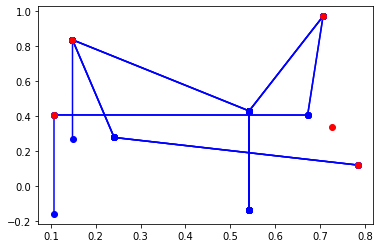

Optimal E_min: 57.84410912014128


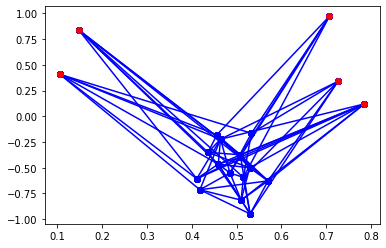

In [9]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from data.tens_struct_data import (n, N, A, p,
        g, x_fixed, y_fixed, m, k_tot,
        k_unif, x_unif, y_unif, )

def plot(x_opt, y_opt, k_opt):
    ind_ex = np.where(k_opt < 1e-2); #do not show springs with k < 1e-2
    Aadj = A[:,np.setdiff1d(np.arange(N),ind_ex)];
    Aadj2 = np.dot(Aadj,Aadj.T)-np.diag(np.diag(Aadj@Aadj.T)) != 0;
    
    for i in range(n):
        for j in range(i):
            if Aadj2[i,j]:
                plt.plot([x_opt[i],x_opt[j]],[y_opt[i],y_opt[j]],"bo-")
    plt.plot(x_fixed,y_fixed,'ro');
    plt.show()

x_prime = cp.Variable(n - p)
y_prime = cp.Variable(n - p)
t = cp.Variable()

x = cp.hstack([x_fixed, x_prime])
y = cp.hstack([y_fixed, y_prime])

obj = cp.Minimize(g * (m @ y) + k_tot * t)

constraints = [
        1/2 * ((A.T @ x)**2 + (A.T @ y)**2) <= t
        ]

problem = cp.Problem(obj, constraints)
problem.solve()

k_opt = constraints[0].dual_value
x_opt = x.value
y_opt = y.value
E_min = problem.value
plot(x_opt, y_opt, k_opt)
print('Optimal E_min:', E_min)
plot(x_unif, y_unif, k_unif)

# 5

problem status: optimal


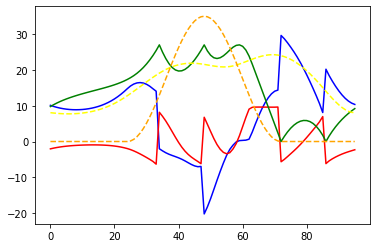

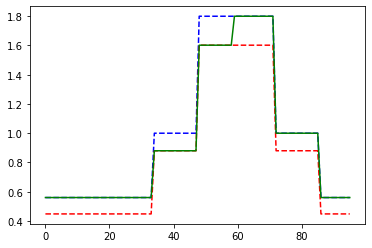

comment is given in pdf file
price_ld > 0 means that ld pays
price_pv: -265.8028
price_grid : -132.6443
price_batt: -33.4800
price_batt + price_pv + price_grid: -431.9272
price_ld (load payes this much): 431.9272
clearly the payments balance


In [12]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from data.microgrid_data import N, p_pv, p_ld, C, D, Q, R_buy, R_sell

p_batt = cp.Variable(N)
p_grid = cp.Variable(N)
q = cp.Variable(N)
#a
constraints = [
        p_batt <= D,
        p_batt >= -C,
        q >= 0,
        q <= Q,
        q[1:] == q[:-1] - p_batt[:-1]/4,
        q[0] == q[-1] - p_batt[-1] / 4,
#         p_ld == p_batt + p_pv + p_grid,
        p_batt + p_pv + p_grid == p_ld
        ]
obj = cp.Minimize(R_sell @ p_grid + (R_buy - R_sell) @ cp.pos(p_grid))
problem = cp.Problem(obj, constraints)
problem.solve()
print(f"problem status: {problem.status}")
time = np.arange(N)
plt.plot(time, p_grid.value, color='blue')
plt.plot(time, p_batt.value, color='red')
plt.plot(time, q.value, color='green')
plt.plot(time, p_ld, color='yellow', linestyle='--')
plt.plot(time, p_pv, color='orange', linestyle='--')
plt.show()
#b
v = -constraints[-1].dual_value
plt.plot(time, 4 * R_buy, color='blue', linestyle='--')
plt.plot(time, 4 * R_sell, color='red', linestyle='--')
plt.plot(time, 4 * v, color='green')
plt.show()
print("comment is given in pdf file")
price_ld = p_ld.dot(v)
price_pv = p_pv.dot(v)
price_grid = p_grid.value.dot(v)
price_batt = p_batt.value.dot(v)
print("price_ld > 0 means that ld pays")
print(f"price_pv: {-price_pv:.4f}")
print(f"price_grid : {-price_grid:.4f}")
print(f"price_batt: {-price_batt:.4f}")
print(f"price_batt + price_pv + price_grid: {-(price_batt + price_pv + price_grid):.4f}")
print(f"price_ld (load payes this much): {price_ld:.4f}")
print("clearly the payments balance")